Edgar Alfredo Briceño Gonzalez

A01221672

Wizeline academy.

# Session 2

## Overview
During this session, you will walk through an exercise of machine learning based on human activity data (e.g. walking, resting, etc.) captured using a smartphone's sensors. You will use unsupervised learning to start, and complement it with a supervised learning algorithm for description purposes.

- You will be provided with some context and the necessary data to perform the exercise. 
- You will perform an analysis to learn how to discriminate between different types of activities.
- You will create a descriptive model using decision trees.

## Human Activity Recognition using Smartphones
Human Activity Recognition (HAR) strives to identify the actions performed by a person from a series of observations of them and their environmental conditions. Some approaches have relied on the use of dedicated motion sensors in different parts of the body, which achieve good classification accuracy. However, these sensors are typically uncomfortable for the common user, so smartphones with their embedded built-in sensors, emerged as an alternative to gather context information about people's actions.

The dataset used in this example was built using inertial data obtained from smartphone accelerometers and gyroscopes. The dataset came from the recordings from 30 subjects doing the following human activities:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying

Applications derived from analyzing this dataset could involve activity logging to provide a summary on a person's lifestyle. The aim of this exercise is to identify features that help discriminate the aforementioned activities. To attain this, Hierarchical Clustering Analysis (HCA), Principal Component Analysis (PCA) and classification trees will be applied.


**References:**

Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. (2013, April). *A Public Domain Dataset for Human Activity Recognition using Smartphones*. In ESANN.

## Dataset Download
If the dataset is not already on the working directory, it can be sourced from the University of California, Irvine (UCI) Machine Learning Repository https://archive.ics.uci.edu/ml/.

In [59]:
%matplotlib inline
import os, requests, zipfile, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import Image
import graphviz
import pydotplus

if not os.path.isdir('./Data/UCI HAR Dataset/'):
    HAR_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
    req = requests.get(HAR_URL)
    compressed = zipfile.ZipFile(io.BytesIO(req.content))
    compressed.extractall('./Data/')

## Read Dataset
The dataset is composed of 561 features recorded from 10,299 observations, and is divided into:
- Training dataset: 7352 observations about 21 subjects
- Testing dataset (not considered): 2947 observations about 9 subjects, which is not present in the training dataset
Review the class distribution to understand how balanced the dataset is. 


In [60]:
def get_key_value_pairs(filename):
    '''Returns the key value pairs, separated by whitespaces,
    that are stored in a file.'''
    
    with open(filename, 'r') as file:
        for line in file.readlines():
            key, value = line.strip().split(' ')
            yield key, value


def HCA(data, class_labels, class_color, method='complete', metric='euclidean'):
    '''Performs Hierarchical Clustering Analysis on data, an
    n by p feature matrix, to plot the corresponding dendrogram
    and return the linkage matrix.'''
    
    merge_dist = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram', size=16)
    plt.xlabel('sample index')
    plt.ylabel(metric+' distance')
    dendrogram(
        merge_dist,
        leaf_rotation=90.,
        leaf_font_size=8.,
        color_threshold=0,
        labels=data.index.values)
    label_color = {str(idx): class_color[class_labels[idx]] for idx in data.index.values}
    ax = plt.gca()
    xlabels = ax.get_xmajorticklabels()
    for label in xlabels:
        label.set_color(label_color[label.get_text()])
    plt.show()
    return merge_dist


def facet_plot(subset, class_assignments, facets, class_color, title, suptitle, legends):
    categories = class_assignments.unique()
    number_classes = len(categories)
    fig = plt.figure(figsize=(12, 3))
    for i in range(facets):
        plt.subplot(1, facets, i+1)
        handlers = []
        for j in categories:
            idx = class_assignments[class_assignments==j].index.values
            handlers.append(plt.scatter(idx, subset.ix[idx,i], color=class_color[j]))
        plt.title(title[i])
        plt.xlabel('Obs Index')
        plt.xticks(rotation=45)
    plt.suptitle(suptitle, size=16, y=1.1)
    fig.legend(handlers, legends, loc='upper center', scatterpoints=1,
               ncol=number_classes, bbox_to_anchor=(0.425,0.14))
    fig.subplots_adjust(bottom=0.3)

In [61]:
activity = {key: value for key, value in get_key_value_pairs('./Data/UCI HAR Dataset/activity_labels.txt')}
act_color = {1:'black', 2:'gold', 3:'magenta', 4:'red', 5:'green', 6:'blue'}
features = [line.strip().split(' ')[1] for line in open('./Data/UCI HAR Dataset/features.txt', 'r')]

Xtrain = pd.read_table('./Data/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True, names=features)
Xtrain['subject'] = [line.strip() for line in open('./Data/UCI HAR Dataset/train/subject_train.txt','r')]
Xtrain['activity'] = pd.read_table('./Data/UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)

Report the row count by activity.

In [62]:
print(pd.crosstab(index=Xtrain['activity'].apply(lambda x: activity[str(x)]), columns='count'))

col_0               count
activity                 
LAYING               1407
SITTING              1286
STANDING             1374
WALKING              1226
WALKING_DOWNSTAIRS    986
WALKING_UPSTAIRS     1073


## Subject 1
Provided that this analysis is exploratory in nature, focus on Subject 1 to isolate the inter-subject variability (name this subset explore). Then, show the importance of selecting the right features as input for HCA.

In [63]:
#print(Xtrain['subject'])
#variable = Xtrain['subject'][1]
#print(variable == '1')
explore = Xtrain.loc[Xtrain['subject'] == '1']


### Non-Discriminative Features
Usually not all features are equally good at separating categories. See an example of an uninformative set of features:



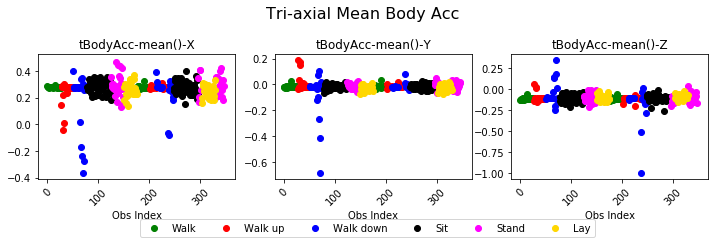

In [64]:
act_legends = ('Walk','Walk up','Walk down','Sit','Stand','Lay')
columns = slice(0,3)
facet_plot(explore.iloc[:,columns], explore.activity, 3, act_color, features[columns],
           'Tri-axial Mean Body Acc', act_legends)

It is clear that this set of features will not help us differentiate between activities, as all of them vary on approximately the same range of values.


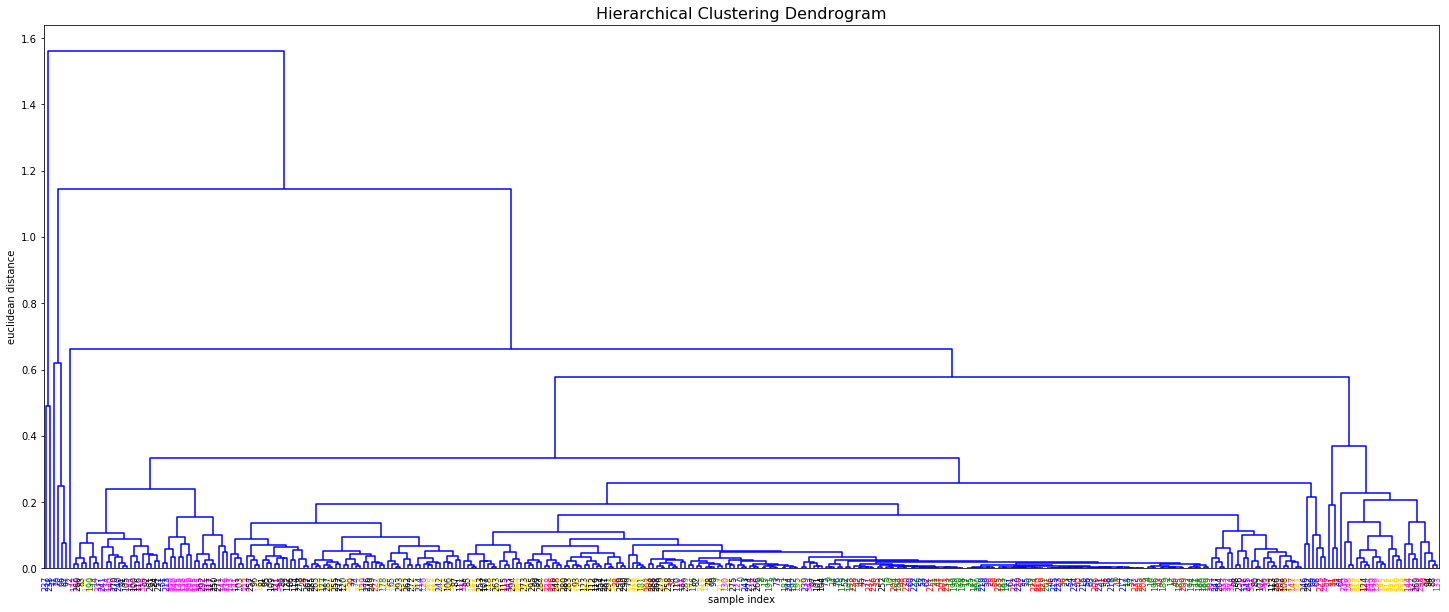

In [65]:
_ = HCA(explore.iloc[:,columns], explore.activity, act_color)   

As foreseen, HCA was not able to find good clusters provided that ID-label colors are scrambled without a clear pattern.

### Discriminative Features
To contrast our previous findings, choose a different set, namely the Tri-axial Max Body Acceleration (columns 9 through 11), and plot the corresponding values:

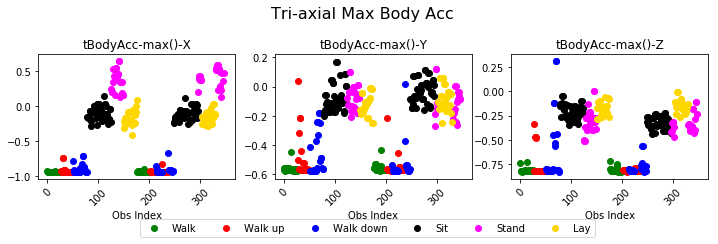

In [67]:
act_legends = ('Walk','Walk up','Walk down','Sit','Stand','Lay')
columns = slice(9,12)
facet_plot(explore.iloc[:,columns], explore.activity, 3, act_color, features[columns],
           'Tri-axial Max Body Acc', act_legends)

Now, the distinction between the subset {Sitting, Standing,Lying} and the subset {Walking, Walking Upstairs, Walking Downstairs} is obvious, particularly on the X-axis. If intuition is correct, HCA should now be able to at least differentiate these activity subsets, so test your hypothesis:

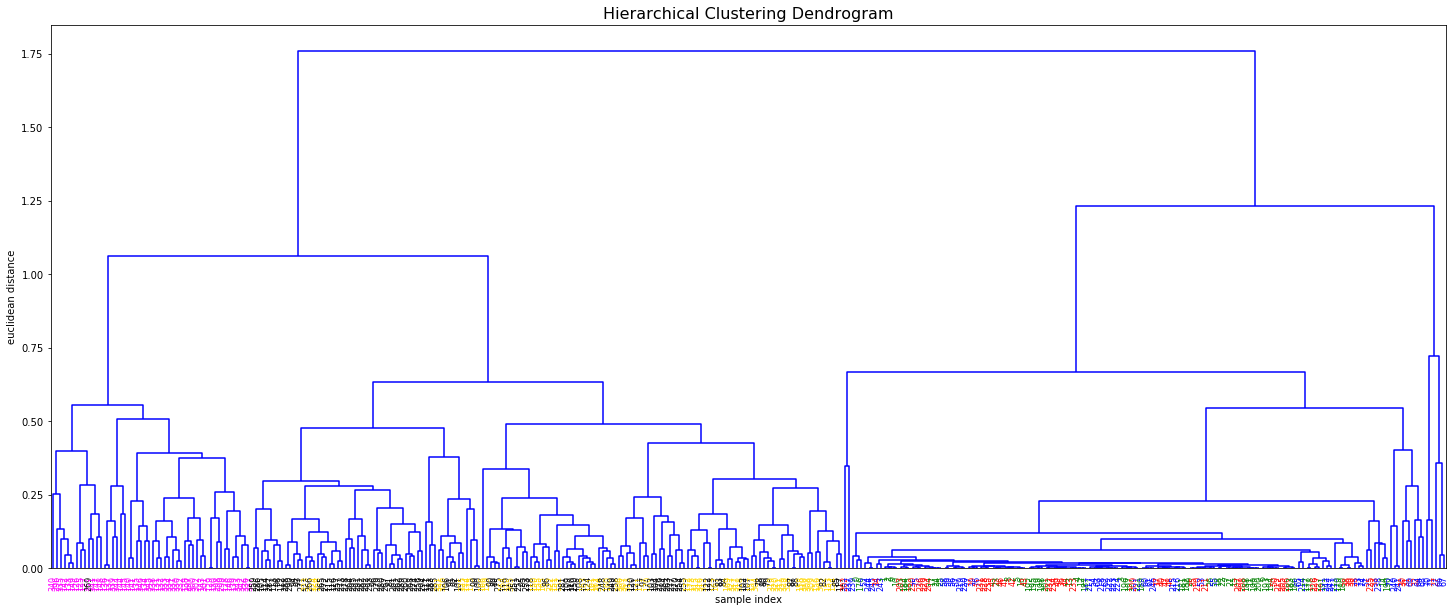

In [68]:
_ = HCA(explore.iloc[:,columns], explore.activity, act_color)   

Again, HCA confirms your findings in the previous plots by making the distinction between static and dynamic activities. Nonetheless, it may be harder to discriminate between activities belonging to the same subset.


## Strategy
After exploring some of the features available, you realize that it is relatively easy to discriminate between dynamic activities {Walking, Walking Upstairs, Walking Downstairs} and static activities {Sitting, Standing,Lying}.

Thus, you will explore a hierarchical strategy, in that you will first determine whether an activity is dynamic or static, and then you will try to identify such activity. To aid in this endeavor, you will apply PCA to identify Principal Components (PCs) that help separate activities belonging to the same set to further examine which features contribute the most in the specification of such PCs.

In [69]:
explore_stat = explore[explore.activity.isin([4,5,6])]
explore_stat_col = [act_color[explore_stat.activity[idx]] for idx in explore_stat.index.values]

explore_dyn = explore[explore.activity.isin([1,2,3])]
explore_dyn_col = [act_color[explore_dyn.activity[idx]] for idx in explore_dyn.index.values]

### PCA on Dynamic Activities



In [70]:
pca_dyn = PCA(n_components=20, svd_solver='full')
scores_dyn = pca_dyn.fit_transform(explore_dyn.iloc[:,:561])
scores_dyn = pd.DataFrame(scores_dyn, index=explore_dyn.index.values)
print('Total variance explained by the first 20 PCs: {}'.format(np.round(sum(pca_dyn.explained_variance_ratio_), 4)))

Total variance explained by the first 20 PCs: 0.8018


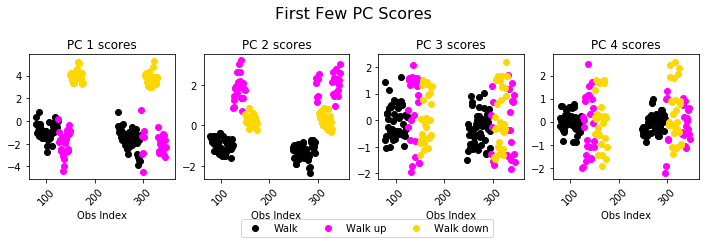

In [71]:
titles = ['PC {} scores'.format(i) for i in range(1,5)]
act_legends = ('Walk','Walk up','Walk down')
facet_plot(scores_dyn.iloc[:,0:4], explore_dyn.activity, 4, act_color, titles, 'First Few PC Scores', act_legends)

When looking at PC1 scores, it is notorious how Walking Upstairs (golden color) departs from the other activities by showing positive values. On the other hand, you can see that Walking (black color) is somewhat separated from the rest on PC2 by taking negative scores.

You will now analyze which features contribute the most to the score compositions by finding the maximum absolute loadings of PC1 & PC2, respectively. Then you will apply HCA on the max contributors to see whether you can correctly cluster the observations:

fBodyGyro-kurtosis()-Y


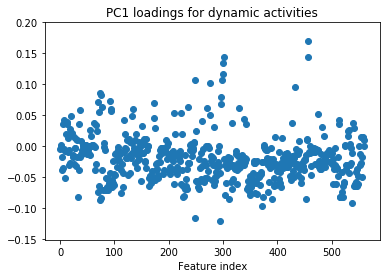

In [72]:
row = slice(0,1)
max_load_pc1_dyn = np.argmax(np.abs(pca_dyn.components_[row]))
print(features[max_load_pc1_dyn])
plt.scatter(np.arange(len(features)),pca_dyn.components_[row])
plt.title('PC1 loadings for dynamic activities')
plt.xlabel('Feature index')

fBodyGyro-maxInds-X


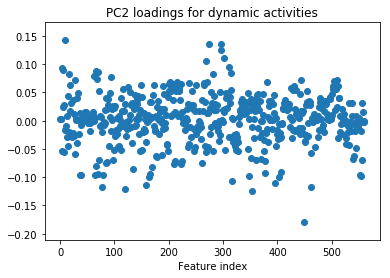

In [73]:
row = slice(1,2)
max_load_pc2_dyn = np.argmax(np.abs(pca_dyn.components_[row,:]))
print(features[max_load_pc2_dyn])
plt.scatter(np.arange(len(features)),pca_dyn.components_[row,:])
plt.title('PC2 loadings for dynamic activities')
plt.xlabel('Feature index')

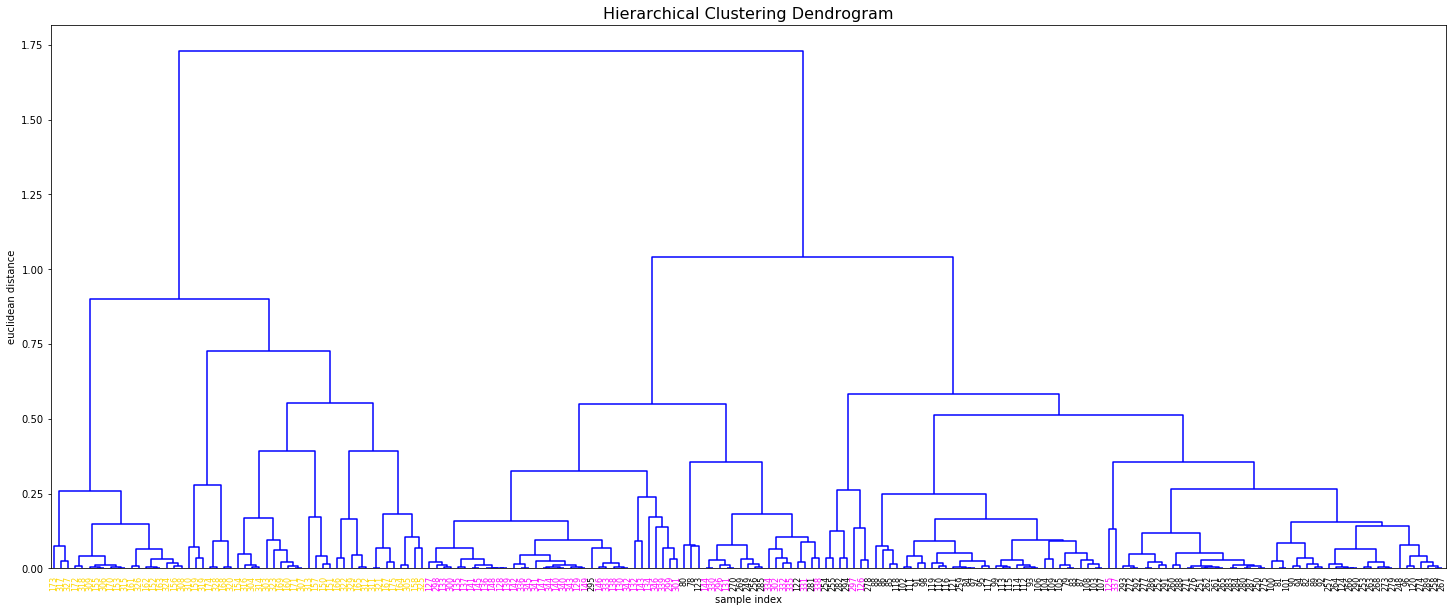

In [74]:
sel_feat_dyn = [max_load_pc1_dyn] + [max_load_pc2_dyn]
_ = HCA(explore_dyn.iloc[:,sel_feat_dyn], explore_dyn.activity, act_color)

Now HCA effectively clusters the majority of the 197 observations, incurring in just 15 errors.


### PCA on Static Activities
Replicate the previous analysis for the static activities to see which PCs help in the separation of classes. First, apply PCA on the corresponding subset and report the total variance explained by the first 20 PCs:

In [75]:
pca_stat = PCA(n_components=20, svd_solver='full')
scores_stat = pca_stat.fit_transform(explore_stat.iloc[:,:561])
scores_stat = pd.DataFrame(scores_stat, index=explore_stat.index.values)
print('Total variance explained by the first 20 PCs: {}'.format(np.round(sum(pca_stat.explained_variance_ratio_), 4)))

Total variance explained by the first 20 PCs: 0.8474


Now, plot the scores of the first 4 PCs. Which ones help you the most to separate the classes? Why?


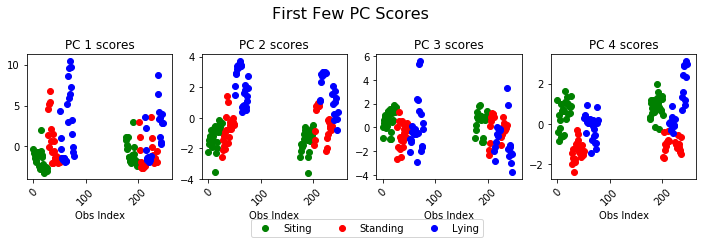

In [76]:
titles = ['PC {} scores'.format(i) for i in range(1,5)]
act_legends = ('Siting','Standing','Lying')
facet_plot(scores_stat.iloc[:,0:4], explore_stat.activity, 4, act_color, titles, 'First Few PC Scores', act_legends)

When looking at PC2 scores, Lying (blue color) separates from the other activities by showing positive values. On the other hand, you can see that Sitting (red color) tries to depart from the rest on PC4 by taking negative scores (although Lying overlaps a bit).

Analyze which features contribute the most to the score compositions by finding the maximum absolute loadings of PC2 and PC4, respectively. Then, apply HCA on the max contributors to see whether you can correctly cluster the observations:

tGravityAcc-energy()-X


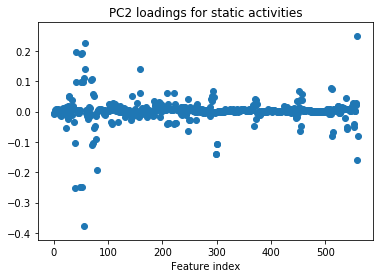

In [77]:
row = slice(1,2)
max_load_pc1_stat = np.argmax(np.abs(pca_stat.components_[row]))
print(features[max_load_pc1_stat])
plt.scatter(np.arange(len(features)),pca_stat.components_[row])
plt.title('PC2 loadings for static activities')
plt.xlabel('Feature index')

tGravityAcc-correlation()-X,Y


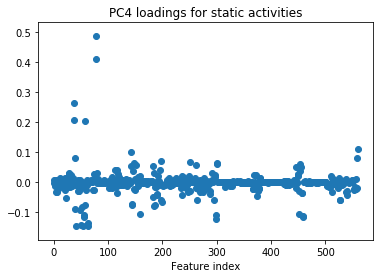

In [78]:
row = slice(3,4)
max_load_pc2_stat = np.argmax(np.abs(pca_stat.components_[row,:]))
print(features[max_load_pc2_stat])
plt.scatter(np.arange(len(features)),pca_stat.components_[row,:])
plt.title('PC4 loadings for static activities')
plt.xlabel('Feature index')

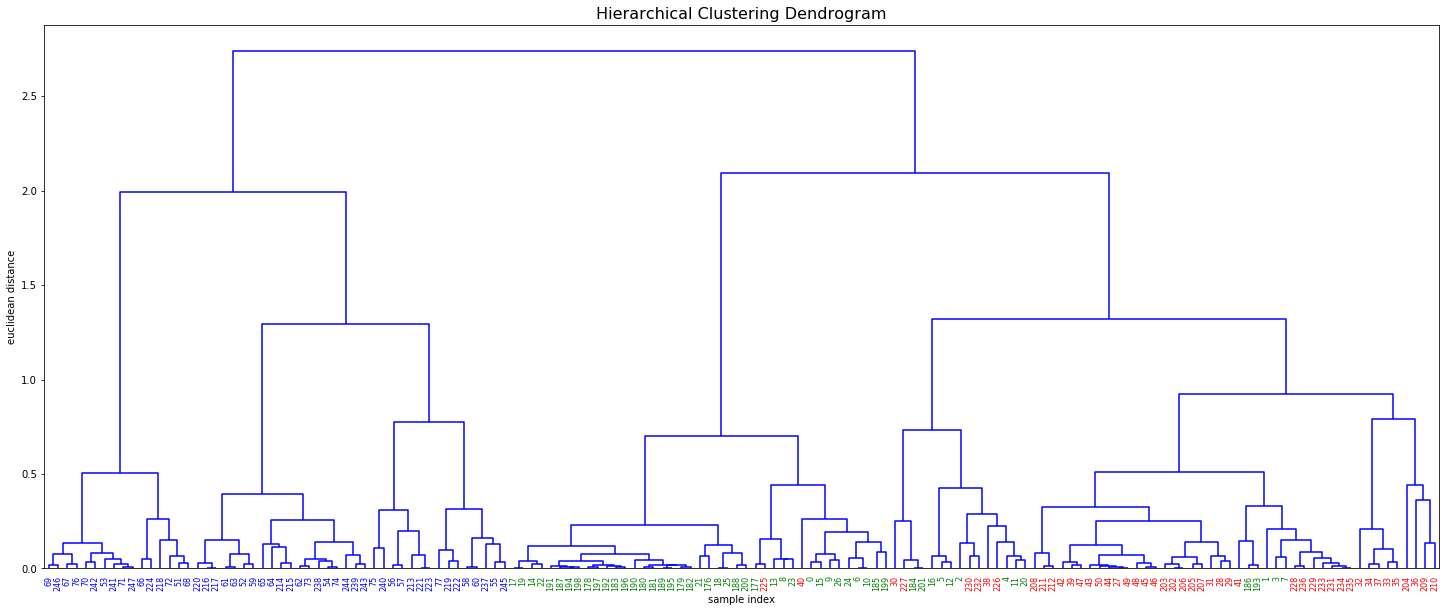

In [79]:
sel_feat_stat = [max_load_pc1_stat] + [max_load_pc2_stat]
_ = HCA(explore_stat.iloc[:,sel_feat_stat], explore_stat.activity, act_color)

Once more, HCA effectively clusters the majority of the 150 observations, which incur in 16 errors.
From the exploratory analysis performed, you can conclude that you might build a hierarchical classifier where:
1. A distinction is made between static and dynamic activities.

    **Note:** Rely on features such as `tBodyAcc-max()-X`.
2. Then if an activity has been regarded as:
    1. Dynamic, you can employ `fBodyGyro-kurtosis()-Y` and `fBodyGyro-maxInds-X` to identify it.
    2. Static, you can employ `tGravityAcc-energy()-X` and `tGravityAcc-correlation()-X,Y` to identify it.



## Descriptive Model
So far you have employed unsupervised learning for analyzing the dataset at hand. Now you want to learn a descriptive model in a supervised way, specifically a classification tree with the Gini index as the criterion to be minimized. The reason of this is two-fold:
- Your exploratory analysis suggested a hierarchical approach, which is intimately related to tree data structures.
- While trees do not have a high predictive power, they provide an easy way to understand patterns in a dataset.

Before building your classification tree, please note that the sklearn implementation does not support cost-complexity pruning. Therefore, you will manually control its complexity by specifying a minimum number of observations per leaf.

Select the five features suggested by our exploratory analysis:

In [80]:
sel_feat = [9] + sel_feat_dyn + sel_feat_stat
print(_.shape)
print(Xtrain[sel_feat].shape)
print(Xtrain['activity'].shape)


(149, 4)
(7352, 5)
(7352,)


Create a cart object (cart_tot), fit the data and make prediction about class memberships (pred_tot). You may refer to:
- API description and specifications: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
- Examples for how to use the sklearn API: http://scikit-learn.org/stable/modules/tree.html

In [129]:
X, Y = explore[sel_feat], explore.activity
 
cart_tot = DecisionTreeClassifier()
cart_tot.fit(X, Y)
pred_tot= cart_tot.predict(X)
print(X.shape)
print(Y.shape)

(347, 5)
(347,)


In [130]:
print(class_names)
print('Accuracy: {}'
      .format(np.round(accuracy_score(y_true=explore.activity, y_pred=pred_tot, normalize=True), 4)))
confusion_matrix(y_true=Y, y_pred=pred_tot)

['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
Accuracy: 1.0


array([[95,  0,  0,  0,  0,  0],
       [ 0, 53,  0,  0,  0,  0],
       [ 0,  0, 49,  0,  0,  0],
       [ 0,  0,  0, 47,  0,  0],
       [ 0,  0,  0,  0, 53,  0],
       [ 0,  0,  0,  0,  0, 50]])

Finally, visualize the tree model:

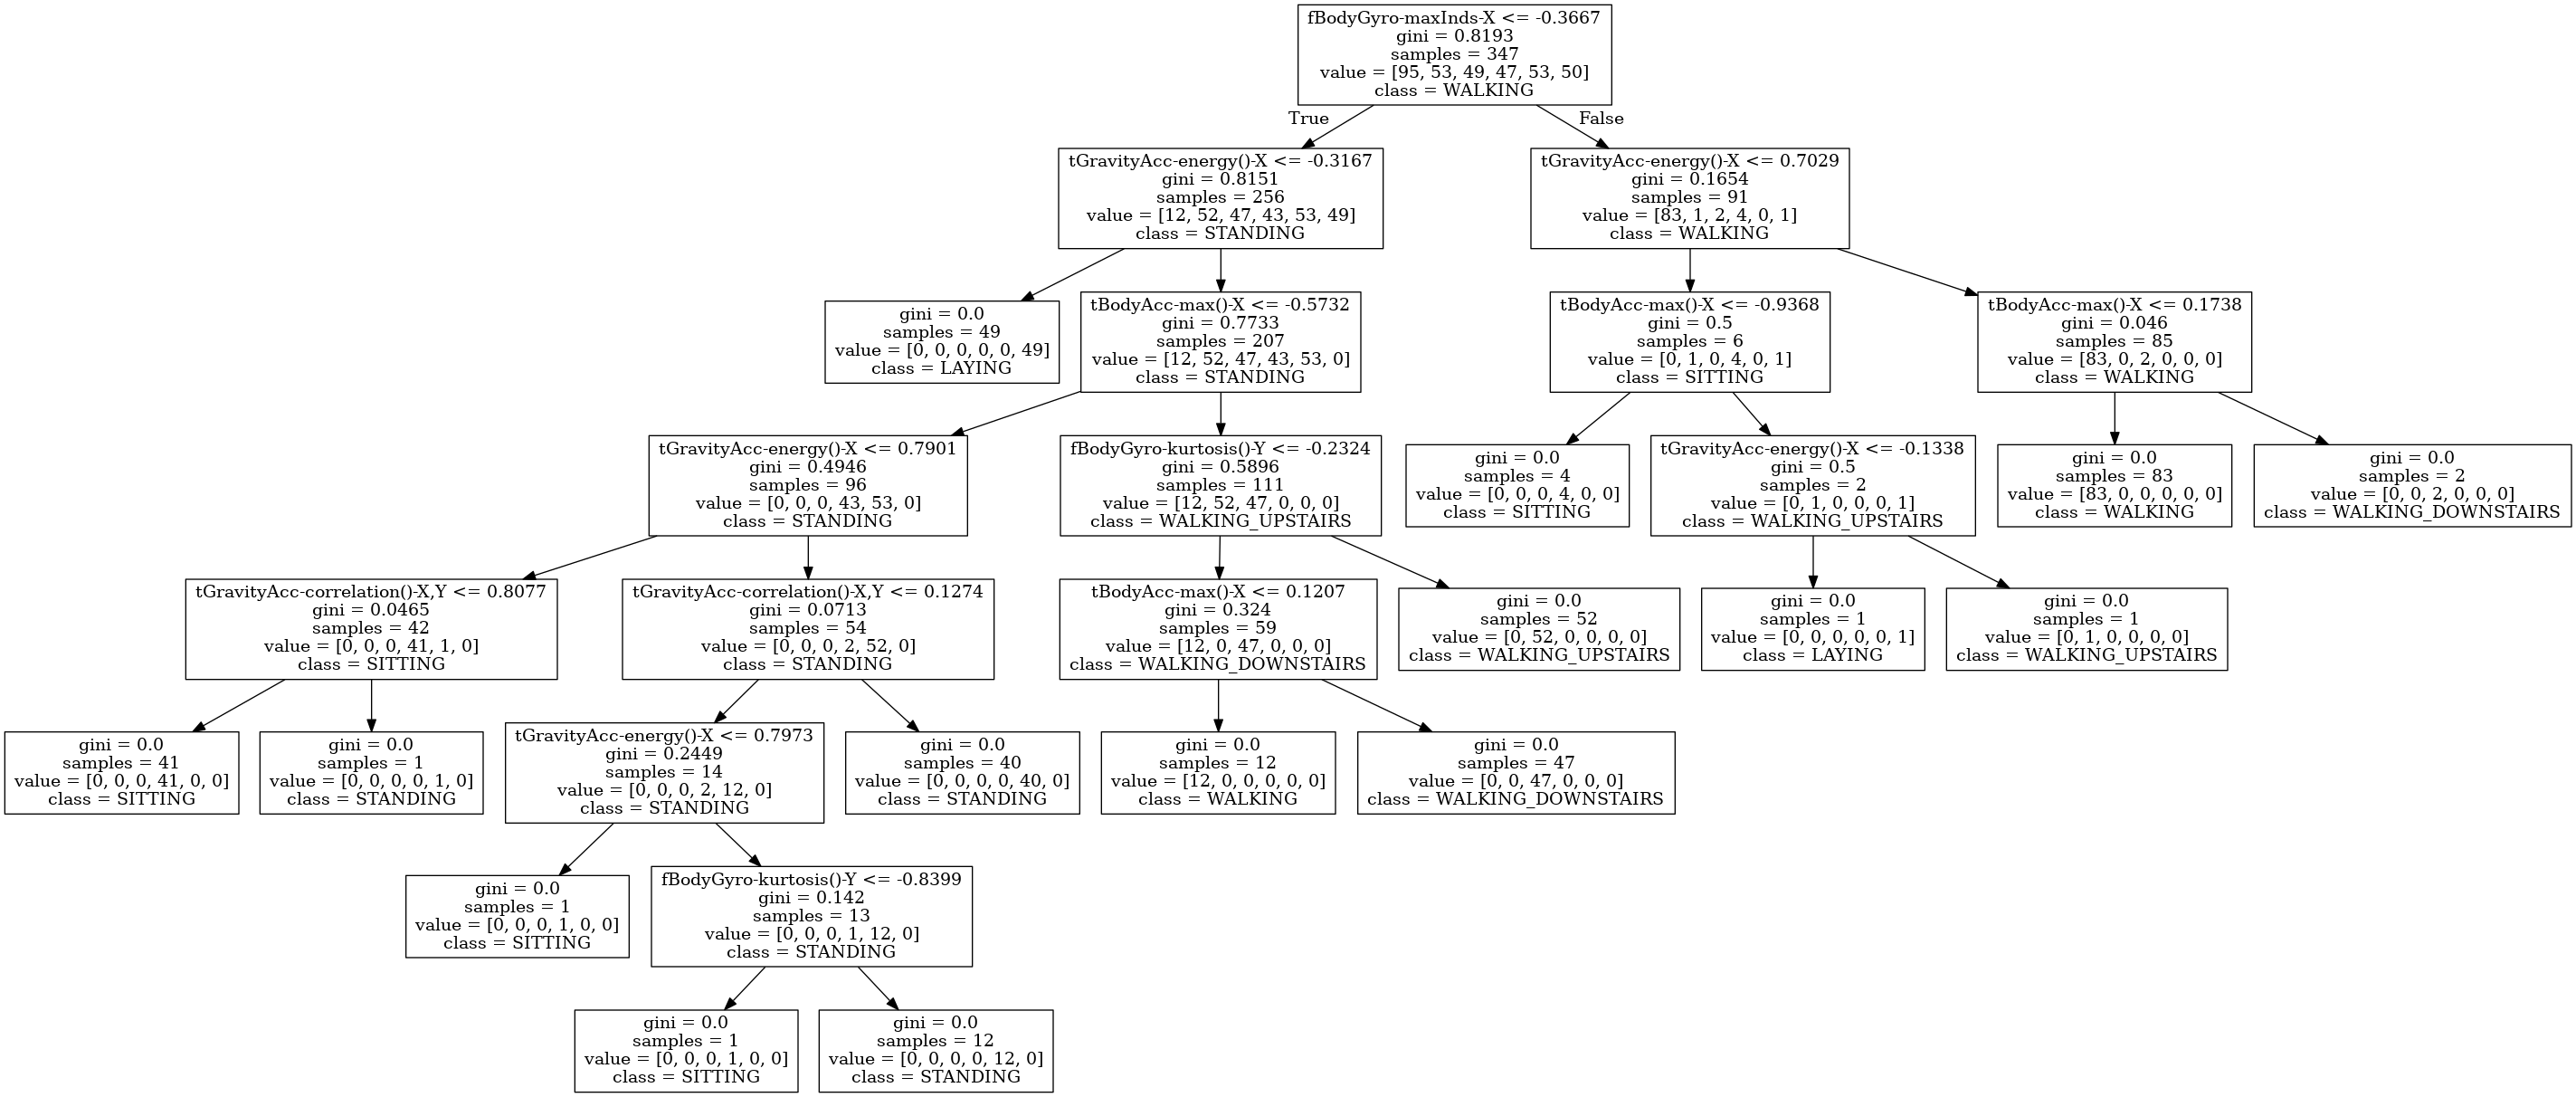

In [131]:
dot_data = export_graphviz(cart_tot, out_file=None, 
                         feature_names=[features[el] for el in sel_feat],  
                         class_names=[activity[str(el)] for el in [1,2,3,4,5,6]]
                         )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

In [85]:
class_names
print(activity)

{'1': 'WALKING', '2': 'WALKING_UPSTAIRS', '3': 'WALKING_DOWNSTAIRS', '4': 'SITTING', '5': 'STANDING', '6': 'LAYING'}


## Conclusions
You were able to hack a dataset with hundreds of variables and derive a fairly simple descriptive model, relying on just five features to provide 93% accuracy. Notwithstanding, you have to bear in mind some limitations:
1. This analysis was performed with descriptive purposes, so the output model should not be extrapolated on unseen observations.
2. If a predictive model were to be built using Subject 1, it is not guaranteed to perform well when classifying activities done by different subjects.


# Notes and conclusions.

Activity recognition aims to recognize the actions and goals of one or more agents from a series of observations on the agents' actions and the environmental conditions. Since the 1980s, this research field has captured the attention of several computer science communities due to its strength in providing personalized support for many different applications and its connection to many different fields of study such as medicine, human-computer interaction, or sociology.

We aim to find patters using the University of California data set the dataset used in this example was build using inertial data obtained from smartphone accelerometers and gyroscopes. The dataset came from the recordings from 30 subjects doing the following human activities:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying


In this document I write down some of my observations by header


In the **dataset download** we extracted the information from the ICS website and extracted the compressed data


While **reading the dataset** we extracted some of the observations to create a training dataset. Aproximately 70% of the data was used for the porpouse of this example. 


In the **reading the dataset** header we also made some useful functions. `get_key_value_pairs(filename):` makes it confortable to extract information from the dataset. `HCA` was useful to create and plot the results of theHierarchical Clustering Analysis most of the information was presented by dendrogram since only having the values is not really useful for the study of the dataset. `facet_plot` created plots of diferent categories to visualise the distance between them. At the end of this we Report the row count by activity.


In **Subject 1** we make some experimentation of the data and see how some features are not feed to separate by categories. In *Non-Discriminative Features* The scatter plot clearly shows that most of the information is more or less at the same range height and this makes it really hard for the HCA to polarice in diferent categories the data. In the dendrogram its clear how most of the categories are so close togheter that they are not representative at all. On the other hand *Discriminative Features* takes features that clearly contrast with each other `'Walk','Walk up','Walk down','Sit','Stand','Lay'` are features that clearly contrast with each other in each of their max acceleration, that was easy to intuit but we made it even clearer by plotting the values. We follow the scatter plot with the dendrogram; the categories this time were very far apart at the beggining but they were harder to discriminate along the same subset.


**Strategy** At this point we have discovered that there are some features that are really easy to diference from one another, the static and dynamic activities are very recognisable one from other, we use  **PCA** to discriminate between this two crearly diferent subsets. As explained in class *Principal component analysis* is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of distinct principal components is equal to the smaller of the number of original variables or the number of observations minus one.


 **Descriptive Model**  In this part of the exercice we have discovered that there is a relation as a tree structure in the data analysis and while the trees we have studied until now were useful they are not very accurate at predicting patterns. Now we need supervised learning algorithm for description purposes. We used the *Decision Tree Classifier* in the sklearn library. I would like to point out that in this exercise I leave the `min_sample_leaf` in the default value of 1, because the sample size is small and the max depth of this tree was of only 8. With at less one member per leaft we reached a 100 percent accuracy I kept experimenting with the min sample leaf and found a 90% accuracy with `min_sample_leaf=47`  and a  a 95% accuracy with `min_sample_leaf=18`. In my opinion the sample size of the leaf must not be leaft to 1 per leaf since that in most of the cases when we are not using training data but testing data our algorithm would not fit every need. In general de DecisionTreeClassifier is a very versatile function `DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)` For me the most notable one was the criterion; the *criterion*  measure the quality of the split, the default split is the gini, the Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. There are many others that are useful to determinate the depgth of the tree in case that no min sample was given or the splitter that can be the `best` or `random` that self explanatorily diference if each category was to be chosen at random or not. At the very end we create the confusion matrix and the decision tree, the confusion matrix shows true positives, false positives, false negatives, true positives and false negatives. according to were the data was clasified in the decision tree. On the other hand the decision tree selects the two diferent paths in with the data is classified in the tree. The leafs or nodes of the tree that have no children are the part were a certain amount of individual touples of information fit in to the scheme. Once more I would like to highlight that due to the low amount of data presented in this example and although I experimented with diferent heights and amount of leafs I leave it as it is because the deapth. 


## Conclusions.
In this practiced I learned the importance of the supervised and unsupervised algorithms. In the supervised, all data is labeled and the algorithms learn to predict the output from the input data. In the unsupervised: All data is unlabeled and the algorithms learn to inherent structure from the input data.
In this particular case the unsupervised algorithms that we used at the begining of the practice worked very well as a reference, where we appreciated that there was some relationship between the dataset and could expose the contrast between two very diferent kind clusters. The supervised algorith was really practical and was useful to shape down the real structure that at the end was the information of the training data. The depth, the criterion, the amount of leafs are all to be taken into account when making the algorithm model.

# References
 https://en.wikipedia.org/wiki/Gini_coefficient
 https://en.wikipedia.org/wiki/Confusion_matrix
 http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
 http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
 http://scikit-learn.org/stable/modules/tree.html
